In [38]:
import os
import re
import string

import numpy as np
from tqdm import tqdm
from asrtoolkit import wer, cer

import _pickle as pickle

import sys
sys.path.insert(0, '..')

from enums.language import Language

In [39]:
def get_folder_paths():
    newseye_path = os.path.join('..', 'data', 'newseye')

    icdar_2017_path = os.path.join(newseye_path, '2017', 'full')
    icdar_2019_path = os.path.join(newseye_path, '2019', 'full')

    result = {
        Language.English: [
            os.path.join(icdar_2017_path, 'eng_monograph'),
            os.path.join(icdar_2017_path, 'eng_periodical'),
            os.path.join(icdar_2019_path, 'EN')
        ],
        Language.Dutch: [
            os.path.join(icdar_2019_path, 'NL', 'NL1')
        ],
        Language.French: [
            os.path.join(icdar_2017_path, 'fr_monograph'),
            os.path.join(icdar_2017_path, 'fr_periodical'),
            os.path.join(icdar_2019_path, 'FR', 'FR1'),
            os.path.join(icdar_2019_path, 'FR', 'FR2'),
            os.path.join(icdar_2019_path, 'FR', 'FR3'),
        ],
        Language.German: [
            os.path.join(icdar_2019_path, 'DE', 'DE1'),
            os.path.join(icdar_2019_path, 'DE', 'DE2'),
            os.path.join(icdar_2019_path, 'DE', 'DE3'),
            os.path.join(icdar_2019_path, 'DE', 'DE4'),
            os.path.join(icdar_2019_path, 'DE', 'DE5'),
            os.path.join(icdar_2019_path, 'DE', 'DE6'),
            os.path.join(icdar_2019_path, 'DE', 'DE7'),
        ]
    }

    return result

In [64]:
def simple_cer(text1, text2):

    total = len(text1)
    matches = 0
    for char1, char2 in zip(text1, text2):
        if char1 == char2:
            matches += 1

    result = (total - matches) / float(total)
    return result

In [87]:
def save_cache(cache_filepath, cache_obj):
    with open(cache_filepath, 'wb') as cache_file:
        pickle.dump(cache_obj, cache_file)

def calculate_error_rates(specific_language: Language = None):
    result = {}

    paths_by_language = get_folder_paths()

    for language, folder_paths in paths_by_language.items():
        if specific_language is not None and language != specific_language: continue

        tot = 0
        paths = []
        for folder_path in folder_paths:
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                paths.append(file_path)

        # result[language] = {
        #     'wer': np.zeros(len(paths)),
        #     'cer': np.zeros(len(paths))
        # }
        result[language] = {
            'wer': [],
            'cer': []
        }

        # result[language]['wer'].fill(-1)
        # result[language]['cer'].fill(-1)

        cache_filepath = os.path.join('results', f'errors_cache_{language.value}.pickle')
        if os.path.exists(cache_filepath):
            with open(cache_filepath, 'rb') as cache_file:
                cache = pickle.load(cache_file)
        else:
            cache = result[language]

        for i, file_path in enumerate(tqdm(paths, desc=f'Computing \'{language.value}\'', total=len(paths))):
            with open(file_path, 'r', encoding='utf-8') as text_file:

                file_lines = text_file.readlines()
                gt_line = file_lines[2][14:].rstrip()
                ocr_line = file_lines[1][14:].rstrip()

                # if len(cache['wer']) > i + 1:
                #     result[language]['wer'].append(cache['wer'][i])
                #     result[language]['cer'].append(cache['cer'][i])
                #     continue

                cer_func = simple_cer
                if len(gt_line) != len(ocr_line):
                    tot += 1
                    # cer_func = cer
                    continue

                n = 2000
                if len(gt_line) > n:
                    gt_chunks = [gt_line[i:i+n] for i in range(0, len(gt_line), n)]
                    ocr_chunks = [ocr_line[i:i+n] for i in range(0, len(ocr_line), n)]

                    temp_wer = []
                    temp_cer = []
                    for gt_chunk, ocr_chunk in zip(gt_chunks, ocr_chunks):
                        words_amount = len(gt_chunk.split())
                        temp_wer.append(wer(gt_chunk, ocr_chunk) / words_amount)
                        temp_cer.append(cer_func(gt_chunk, ocr_chunk))

                    result[language]['wer'].append(np.mean(temp_wer))
                    result[language]['cer'].append(np.mean(temp_cer))
                else:
                    words_amount = len(gt_line.split())
                    result[language]['wer'].append(wer(gt_line, ocr_line) / words_amount)
                    result[language]['cer'].append(cer_func(gt_line, ocr_line))

                if i % 10 == 0:
                    save_cache(cache_filepath, cache)

        print(language, tot)

    return result

In [88]:
error_rates_per_language = calculate_error_rates()

Computing 'english': 100%|██████████| 963/963 [00:14<00:00, 67.41it/s] 


english 12


Computing 'dutch': 100%|██████████| 150/150 [00:01<00:00, 81.30it/s]


dutch 1


Computing 'french': 100%|██████████| 3993/3993 [00:27<00:00, 143.46it/s]


french 377


Computing 'german': 100%|██████████| 10032/10032 [00:09<00:00, 1003.20it/s]


german 8294


In [89]:
print([(lang, len(x['wer'])) for lang, x in error_rates_per_language.items()])

[(<Language.English: 'english'>, 951), (<Language.Dutch: 'dutch'>, 149), (<Language.French: 'french'>, 3616), (<Language.German: 'german'>, 1738)]


In [159]:
for language, error_rates in error_rates_per_language.items():
    print(f'{language.value.capitalize()} & {round(np.mean(error_rates["cer"]), 3)} & {round(np.mean(error_rates["wer"]), 3)} \\\\')
    # print(f'\\item {language.value.capitalize()} CER: {round(np.mean(error_rates["cer"]), 3)}')

English & 0.075 & 13.894 \\
Dutch & 0.292 & 42.788 \\
French & 0.065 & 4.995 \\
German & 0.242 & 1.15 \\


In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'cm'

sns.set()
sns.set(font_scale=2)  # crazy big
sns.set_style('ticks')

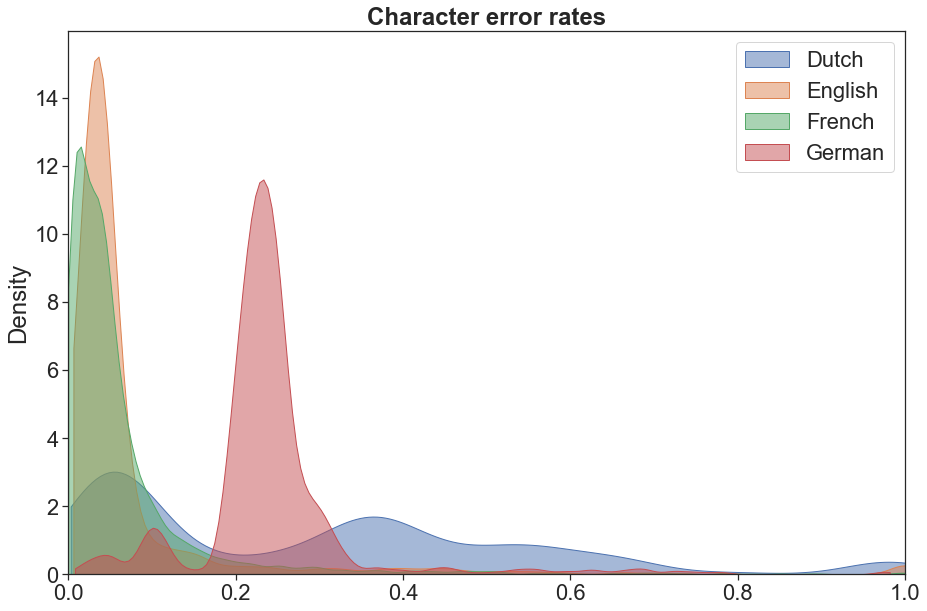

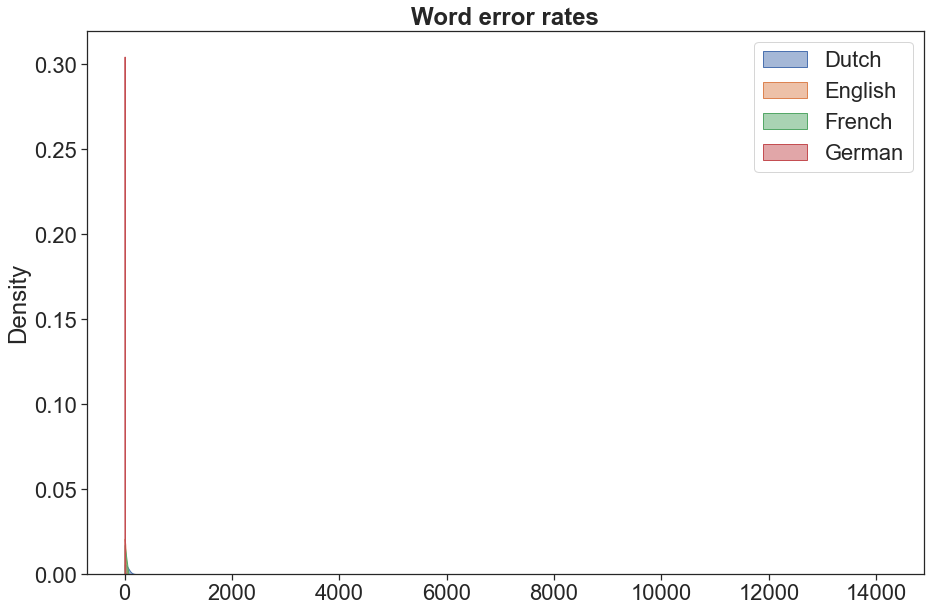

In [157]:
def plot_errors_dist(errors, labels, title, use_lim=False):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for error_values, label in zip(errors, labels):
        ax = sns.kdeplot(
            data=error_values,
            fill=True,
            bw_adjust=.5,
            cut=0,
            clip=(0,1) if use_lim else None,
            label=label,
            legend=True,
            # linewidth=0,
            alpha=.5,
            ax=ax
        )

    if use_lim:
        ax.set_xlim(0, 1)

    ax.set_title(title, fontdict={'fontweight': 'bold'}, pad=None)
    ax.legend()
    plt.savefig(os.path.join('results', title.lower().replace(' ', '_')), bbox_inches='tight')

plot_errors_dist([
    error_rates_per_language[Language.Dutch]['cer'],
    error_rates_per_language[Language.English]['cer'],
    error_rates_per_language[Language.French]['cer'],
    error_rates_per_language[Language.German]['cer']
    ],
    labels=['Dutch', 'English', 'French', 'German'],
    title='Character error rates',
    use_lim=True)

plot_errors_dist([
    error_rates_per_language[Language.Dutch]['wer'],
    error_rates_per_language[Language.English]['wer'],
    error_rates_per_language[Language.French]['wer'],
    error_rates_per_language[Language.German]['wer']
    ],
    labels=['Dutch', 'English', 'French', 'German'],
    title='Word error rates')

In [ ]:
def calculate_language_data_size():
    paths_by_language = get_folder_paths()
    result = {}

    for language, folder_paths in paths_by_language.items():

        paths = []
        for folder_path in folder_paths:
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                paths.append(file_path)

        result[language] = {
            'chars': 0,
            'words': 0
        }

        for file_path in tqdm(paths, desc=f'Computing \'{language.value}\'', total=len(paths)):
            with open(file_path, 'r', encoding='utf-8') as text_file:

                file_lines = text_file.readlines()
                gt_line = file_lines[2][14:]

                chars = len(gt_line)
                words = len(gt_line.split())
                result[language]['chars'] += chars
                result[language]['words'] += words

    print(result)

calculate_language_data_size()

In [69]:
error_rates_per_language[Language.Dutch]['cer'][2]

0.08753819762122599